#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Natural Language Understanding: Word Embeddings

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Lab outline
  1. Creating the vocabulary
  1. The co-occurrence matrix
  1. Constructing a sparse counts matrix
  1. Toy corpus example
  1. Positive pointwise mutual information
  1. Computing word vectors with SVD
  1. Visualization
  1. t-SNE for better visualizations
  1. Takeaways
  1. Experiments

Instead of using Wordnet, let's investigate more data-driven approaches to creating representations of meaning for words. John Rupert Firth, a 20th century linguist, inspired this line of work when he said "You shall know a word by the company it keeps." That is, let's try to infer something about semantics from the distributional statistics of how words are used in context.

Early work on [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics) involved clustering words together with similar distributional statistics. The widely used [Brown clustering algorithm](https://en.wikipedia.org/wiki/Brown_clustering), developed at IBM by Peter Brown in the early 1990s, produces a hierarchical clustering directly from data with some similarity to the Wordnet hierarchy produced by hand.

Here, we'll take a step past clusters and start exploring **word embeddings** -- learned mappings of words to continuous vectors. Embedding space allows us to compute the distance between words (in Euclidean space) while preserving the nuance that differentiates synonyms (this nuance is lost in a clustering). Embeddings directly address the sparsity problem with language -- rather than parameterize all of the language with a sparse set of atomic words (or word n-grams), we parameterize it in a single, shared, fairly low dimensional space -- say 100 dimensions. So instead of a million words, we have 100 semantic axes.

This notebook starts to address the problem of learning a mapping from words to vectors, an idea that has become the foundation to just about all modern NLU. At a high level, we'll achieve this by estimating vectors for each word that allow us to reconstruct a large matrix of co-occurrence counts across a corpus.

## Setup

Let's get started with the imports needed for the rest of this lab.

We'll also need to load some utility functions which will help us work with the corpus.

### Imports

Run this code cell to add in all of the imports.

In [2]:
from __future__ import division
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import scipy.sparse
import time

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE as tsne

### bAbI task corpus reader

Start by running the cell below to load the corpus reader.

In [4]:
#@title bAbI Task corpus reader
import sys, os
import glob
import re
from collections import namedtuple

# Struct types for different lines in the bAbI dataset.
# StoryLine represents "ID text" lines as (int, string)
# QALine represents "ID question answer support" lines as
# (int, string, string, list(int)).
# If tokenized, string fields can be replaced with list(string).
StoryLine = namedtuple("StoryLine", ["id", "text"])
QALine = namedtuple("QALine", ["id", "question", "answer", "support_ids"])

class BabiTaskCorpusReader(object):
    """Corpus reader for the bAbI tasks dataset.

    See https://research.fb.com/downloads/babi/ for details.

    This class exposes a similar interface to NLTK's corpus readers, and should
    be interchangable with them in many applications.

    Example usage:

    import babi_utils
    import nltk
    tok = nltk.tokenize.treebank.TreebankWordTokenizer()
    cr = babi_utils.BabiTaskCorpusReader("/home/babi/en",
                                         tokenizer=tok.tokenize)
    words = list(cr.words())
    print words[:8]
    # ['John', 'travelled', 'to', 'the', 'hallway', '.', 'Mary', 'journeyed']

    """

    ALL_FILES = [
        'qa10_indefinite-knowledge_test.txt',
        'qa10_indefinite-knowledge_train.txt',
        'qa11_basic-coreference_test.txt',
        'qa11_basic-coreference_train.txt',
        'qa12_conjunction_test.txt',
        'qa12_conjunction_train.txt',
        'qa13_compound-coreference_test.txt',
        'qa13_compound-coreference_train.txt',
        'qa14_time-reasoning_test.txt',
        'qa14_time-reasoning_train.txt',
        'qa15_basic-deduction_test.txt',
        'qa15_basic-deduction_train.txt',
        'qa16_basic-induction_test.txt',
        'qa16_basic-induction_train.txt',
        'qa17_positional-reasoning_test.txt',
        'qa17_positional-reasoning_train.txt',
        'qa18_size-reasoning_test.txt',
        'qa18_size-reasoning_train.txt',
        'qa19_path-finding_test.txt',
        'qa19_path-finding_train.txt',
        'qa1_single-supporting-fact_test.txt',
        'qa1_single-supporting-fact_train.txt',
        'qa20_agents-motivations_test.txt',
        'qa20_agents-motivations_train.txt',
        'qa2_two-supporting-facts_test.txt',
        'qa2_two-supporting-facts_train.txt',
        'qa3_three-supporting-facts_test.txt',
        'qa3_three-supporting-facts_train.txt',
        'qa4_two-arg-relations_test.txt',
        'qa4_two-arg-relations_train.txt',
        'qa5_three-arg-relations_test.txt',
        'qa5_three-arg-relations_train.txt',
        'qa6_yes-no-questions_test.txt',
        'qa6_yes-no-questions_train.txt',
        'qa7_counting_test.txt',
        'qa7_counting_train.txt',
        'qa8_lists-sets_test.txt',
        'qa8_lists-sets_train.txt',
        'qa9_simple-negation_test.txt',
        'qa9_simple-negation_train.txt'
    ]

    def __init__(self, directory, mask="qa*.txt",
                 file_list=ALL_FILES,
                 file_reader=open,
                 tokenizer=lambda s: s.split(),
                 verbose=False):
        """Construct a corpus reader for the bAbI tasks dataset.

        Args:
            directory: (string) path to bAbI text files (e.g. /home/babi/en/)
            mask: (string) file glob to match particular files. Use
                "qa16_*" e.g. to match task 16.
            file_list: (list(string) or None) If None, will glob directory to
                find files. Otherwise, will use the given list of basenames.
            file_reader: (function string -> fd) optional replacement for
                Python's built-in open(...) method, to be used for reading
                from alternative file-like objects.
            tokenizer: function string -> list(string), used to split
                sentences.
            verbose: (bool) if true, will print when reading files.
        """
        self._open = file_reader
        self._tokenizer = tokenizer
        self._verbose = verbose

        if file_list:
            basenames = glob.fnmatch.filter(file_list, mask)
            filenames = [os.path.join(directory, f) for f in basenames]
        else:
            # Glob directory
            pattern = os.path.join(directory, mask)
            filenames = glob.glob(pattern)

        # Filenames of form qaXX_task-name_train.txt
        # Want to sort by XX as a number
        key_fn = lambda f: (int(os.path.basename(f).split("_")[0][2:]), f)
        self._filenames = sorted(filenames, key=key_fn)
        # Filenames should be nonempty!
        assert(self._filenames), "No files found matching [{:s}]".format(mask)

    def filenames(self):
        return self._filenames

    def parse_line(self, line):
        """Parse a single line from the bAbI corpus.

        Line is of one of the two forms:
        ID text
        ID question[tab]answer[tab]supporting fact IDs

        See https://research.fb.com/downloads/babi/

        Args:
            line: (string)

        Returns:
            (id, text) as (int, string)
            OR (id, question, answer, [ids]) as (int, string, string, list(int))
        """
        id_text, rest = line.split(" ", 1)
        id = int(id_text)
        if "\t" in rest:
            question, answer, s_ids_text = rest.split("\t")
            s_ids = map(int, s_ids_text.split())
            return QALine(id, question.strip(), answer.strip(), s_ids)
        else:
            return StoryLine(id, rest.strip())

    def tokenize_parsed_line(self, line):
        if isinstance(line, StoryLine):
            return StoryLine(line.id, self._tokenizer(line.text))
        else:
            return QALine(line.id,
                          self._tokenizer(line.question),
                          self._tokenizer(line.answer),
                          line.support_ids)

    def _line_iterator(self):
        for f in self._filenames:
            if self._verbose:
                print >> sys.stderr, "Reading {:s}".format(os.path.basename(f)),
            with self._open(f) as fd:
                for line in fd:
                    yield line.strip()
            if self._verbose:
                print >> sys.stderr, "...done!"

    def examples(self, tokenize=True):
        """Iterator over complete stories (training examples).

        A story spans multiple lines, of the form:

        1 text one
        2 text two
        3 text three
        4 question[tab]answer[tab]supporting fact IDs

        Args:
            tokenize: (bool) If true, will tokenize text fields.

        Returns:
            iterator yielding list(StoryLine|QALine)
              if tokenize=True, then text, question, and answer will be
              list(string); otherwise they will be plain strings.
        """
        buffer = []
        for line in self._line_iterator():
            parsed = self.parse_line(line)
            if tokenize:
                parsed = self.tokenize_parsed_line(parsed)
            # If new story item, flush buffer.
            if buffer and parsed.id <= buffer[-1].id:
                yield buffer
                buffer = []
            buffer.append(parsed)
        # Flush at end.
        yield buffer
        buffer = []

    def _raw_sents_impl(self, stories=False, questions=False, answers=False):
        for line in self._line_iterator():
            parsed = self.parse_line(line)
            if isinstance(parsed, StoryLine) and stories:
                yield parsed.text
            else:
                if questions:
                    yield parsed.question
                if answers:
                    yield parsed.answer

    def raw_sents(self):
        """Iterator over utterances in the corpus.

        Returns untokenized sentences.

        Returns:
            iterator yielding string
        """
        return self._raw_sents_impl(stories=True,
                                    questions=True,
                                    answers=True)

    def sents(self):
        """Iterator over utterances in the corpus.

        Returns tokenized sentences, a la NLTK.

        Returns:
            iterator yielding list(string)
        """
        for sentence in self.raw_sents():
            yield self._tokenizer(sentence)


    def words(self):
        """Iterator over words in the corpus.

        Returns:
            iterator yielding string
        """
        for sentence in self.sents():
            for word in sentence:
                yield word

### Text corpora

We need a corpus of text for our experiments. We'll start with the [bAbI corpus](https://research.fb.com/downloads/babi/), a list of simple sentences (generated from a template) with a very small vocabulary. The number of word **tokens** (strings of characters or punctuation delimited by white space or newline) is over 1 million, but the number of word **types** (the vocabulary) is only 162. This corpus makes it easy to verify that our learned embeddings are reasonable, but it's not representative of the tremendous variation and large vocabularies in natural language.

The old standard [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus), by contrast, also contains about 1 million tokens, but over 40,000 types. Incidentally, the Brown corpus is the first major computer-readable linguistic corpus, assembled in 1961 (at Brown University -- no relations to Brown clustering) consisting of American English sampled from 15 different text categories ranging from news text to academic articles to popular fiction.

In [5]:
!wget https://storage.googleapis.com/mledu-datasets/babi_tasks_1-20_v1-2.tar.gz -O /tmp/babi_tasks_1-20_v1-2.tar.gz

--2021-06-03 02:03:31--  https://storage.googleapis.com/mledu-datasets/babi_tasks_1-20_v1-2.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15719851 (15M) [application/gzip]
Saving to: ‘/tmp/babi_tasks_1-20_v1-2.tar.gz’

/tmp/babi_tasks_1-2 100%[===================>]  14.99M  54.2MB/s    in 0.3s    

2021-06-03 02:03:32 (54.2 MB/s) - ‘/tmp/babi_tasks_1-20_v1-2.tar.gz’ saved [15719851/15719851]



In [6]:
import os
import tarfile

local_tar = '/tmp/babi_tasks_1-20_v1-2.tar.gz'
tar_ref = tarfile.open(local_tar, 'r:gz')
tar_ref.extractall('/tmp')
tar_ref.close()

In [9]:
print('Loading bAbI corpus... '),
babi_corpus = BabiTaskCorpusReader(
    "/tmp/tasks_1-20_v1-2/en",
    tokenizer=nltk.tokenize.treebank.TreebankWordTokenizer().tokenize)
print('Done')

Loading bAbI corpus...  Done


Let's make sure we have the data. The corpus object gives us access to the sentences, via corpus.sents(), which is a list of lists of tokens.

(Note: the following code cell may take 20-30 seconds to complete running.)

In [10]:
corpus = list(babi_corpus.sents())
print('Sentences:', len(corpus))

# Print the first 5 sentences of the corpus.
for i, sent in enumerate(corpus[:5]):
    print(i, ' '.join(sent))

('Sentences:', 212802)
(0, 'John travelled to the hallway .')
(1, 'Mary journeyed to the bathroom .')
(2, 'Where is John ?')
(3, 'hallway')
(4, 'Daniel went back to the bathroom .')


### Corpus utilities

Next, let's load some utility functions which will help us work with the corpus. Run each of the following three cells to load them.

In [11]:
#@title Utilities
import re
import time
import itertools
import numpy as np

# For pretty-printing
import pandas as pd
from IPython.display import display, HTML

UNK_TOKEN   = u"<unk>"

def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))

def pretty_print_matrix(M, rows=None, cols=None, dtype=float, float_fmt="{0:.04f}"):
    """Pretty-print a matrix using Pandas.

    Args:
      M : 2D numpy array
      rows : list of row labels
      cols : list of column labels
      dtype : data type (float or int)
      float_fmt : format specifier for floats
    """
    df = pd.DataFrame(M, index=rows, columns=cols, dtype=dtype)
    old_fmt_fn = pd.get_option('float_format')
    pd.set_option('float_format', lambda f: float_fmt.format(f))
    display(df)
    pd.set_option('float_format', old_fmt_fn)  # reset Pandas formatting

def pretty_timedelta(fmt="%d:%02d:%02d", since=None, until=None):
    """Pretty-print a timedelta, using the given format string."""
    since = since or time.time()
    until = until or time.time()
    delta_s = until - since
    hours, remainder = divmod(delta_s, 3600)
    minutes, seconds = divmod(remainder, 60)
    return fmt % (hours, minutes, seconds)


##
# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

##
# Data loading functions
def get_corpus(name="brown"):
    import nltk
    assert(nltk.download(name))
    return nltk.corpus.__getattr__(name)

def build_vocab(corpus, V=10000):
    import vocabulary
    token_feed = (canonicalize_word(w) for w in corpus.words())
    vocab = vocabulary.Vocabulary(token_feed, size=V)
    return vocab

def get_train_test_sents(corpus, split=0.8, shuffle=True):
    """Generate train/test split for unsupervised tasks.

    Args:
      corpus: nltk.corpus that supports sents() function
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.

    Returns:
      train_sentences, test_sentences ( list(list(string)) ): the train and test
      splits
    """
    sentences = np.array(list(corpus.sents()), dtype=object)
    fmt = (len(sentences), sum(map(len, sentences)))
    print "Loaded {:,} sentences ({:g} tokens)".format(*fmt)

    if shuffle:
        rng = np.random.RandomState(shuffle)
        rng.shuffle(sentences)  # in-place
    train_frac = 0.8
    split_idx = int(train_frac * len(sentences))
    train_sentences = sentences[:split_idx]
    test_sentences = sentences[split_idx:]

    fmt = (len(train_sentences), sum(map(len, train_sentences)))
    print "Training set: {:,} sentences ({:,} tokens)".format(*fmt)
    fmt = (len(test_sentences), sum(map(len, test_sentences)))
    print "Test set: {:,} sentences ({:,} tokens)".format(*fmt)

    return train_sentences, test_sentences

def preprocess_sentences(sentences, vocab, use_eos=False, emit_ids=True):
    """Preprocess sentences by canonicalizing and mapping to ids.

    Args:
      sentences ( list(list(string)) ): input sentences
      vocab: Vocabulary object, already initialized
      use_eos: if true, will add </s> token to end of sentence.
      emit_ids: if true, will emit as ids. Otherwise, will be preprocessed
          tokens.

    Returns:
      ids ( array(int) ): flattened array of sentences, including boundary <s>
      tokens.
    """
    # Add sentence boundaries, canonicalize, and handle unknowns
    word_preproc = lambda w: canonicalize_word(w, wordset=vocab.word_to_id)
    ret = []
    for s in sentences:
        canonical_words = vocab.pad_sentence(map(word_preproc, s),
                                             use_eos=use_eos)
        ret.extend(vocab.words_to_ids(canonical_words) if emit_ids else
                   canonical_words)
    if not use_eos:  # add additional <s> to end if needed
        ret.append(vocab.START_ID if emit_ids else vocab.START_TOKEN)
    return np.array(ret, dtype=(np.int32 if emit_ids else object))


def load_corpus(corpus, split=0.8, V=10000, shuffle=0):
    """Load a named corpus and split train/test along sentences.

    This is a convenience wrapper to chain together several functions from this
    module, and produce a train/test split suitable for input to most models.

    Sentences are preprocessed by canonicalization and converted to ids
    according to the constructed vocabulary, and interspersed with <s> tokens
    to denote sentence bounaries.

    Args:
        corpus: (string | corpus reader) If a string, will fetch the
            NLTK corpus of that name.
        split: (float \in (0,1]) fraction of examples in train split
        V: (int) vocabulary size (including special tokens)
        shuffle: (int) if > 0, use as random seed to shuffle sentence prior to
            split. Can change this to get different splits.

    Returns:
        (vocab, train_ids, test_ids)
        vocab: vocabulary.Vocabulary object
        train_ids: flat (1D) np.array(int) of ids
        test_ids: flat (1D) np.array(int) of ids
    """
    if isinstance(corpus, str):
        corpus = get_corpus(corpus)
    vocab = build_vocab(corpus, V)
    train_sentences, test_sentences = get_train_test_sents(corpus, split, shuffle)
    train_ids = preprocess_sentences(train_sentences, vocab)
    test_ids = preprocess_sentences(test_sentences, vocab)
    return vocab, train_ids, test_ids

##
# Window and batch functions
def rnnlm_batch_generator(ids, batch_size, max_time):
    """Convert ids to data-matrix form for RNN language modeling."""
    # Clip to multiple of max_time for convenience
    clip_len = ((len(ids)-1) / batch_size) * batch_size
    input_w = ids[:clip_len]     # current word
    target_y = ids[1:clip_len+1]  # next word
    # Reshape so we can select columns
    input_w = input_w.reshape([batch_size,-1])
    target_y = target_y.reshape([batch_size,-1])

    # Yield batches
    for i in xrange(0, input_w.shape[1], max_time):
        yield input_w[:,i:i+max_time], target_y[:,i:i+max_time]


def build_windows(ids, N, shuffle=True):
    """Build window input to the window model.

    Takes a sequence of ids, and returns a data matrix where each row
    is a window and target for the window model. For N=3:
        windows[i] = [w_3, w_2, w_1, w_0]

    For language modeling, N is the context size and you can use y = windows[:,-1]
    as the target words and x = windows[:,:-1] as the contexts.

    For CBOW, N is the window size and you can use y = windows[:,N/2] as the target words
    and x = np.hstack([windows[:,:N/2], windows[:,:N/2+1]]) as the contexts.

    For skip-gram, you can use x = windows[:,N/2] as the input words and y = windows[:,i]
    where i != N/2 as the target words.

    Args:
      ids: np.array(int32) of input ids
      shuffle: if true, will randomly shuffle the rows

    Returns:
      windows: np.array(int32) of shape [len(ids)-N, N+1]
        i.e. each row is a window, of length N+1
    """
    windows = np.zeros((len(ids)-N, N+1), dtype=int)
    for i in xrange(N+1):
        # First column: first word, etc.
        windows[:,i] = ids[i:len(ids)-(N-i)]
    if shuffle:
        # Shuffle rows
        np.random.shuffle(windows)
    return windows


def batch_generator(data, batch_size):
    """Generate minibatches from data.

    Args:
      data: array-like, supporting slicing along first dimension
      batch_size: int, batch size

    Yields:
      minibatches of maximum size batch_size
    """
    for i in xrange(0, len(data), batch_size):
        yield data[i:i+batch_size]

In [12]:
#@title Vocabulary helper functions
import collections
from collections import defaultdict

class Vocabulary(object):

  START_TOKEN = u"<s>"
  END_TOKEN   = u"</s>"
  UNK_TOKEN   = u"<unk>"

  def __init__(self, tokens, size=None):
    """Create a Vocabulary object.

    Args:
        tokens: iterator( string )
        size: None for unlimited, or int > 0 for a fixed-size vocab.
              Vocabulary size includes special tokens <s>, </s>, and <unk>
    """
    self.unigram_counts = collections.Counter(tokens)
    self.bigram_counts = defaultdict(lambda: defaultdict(lambda: 0))
    word1 = None
    for word in tokens:
        if word1 is None:
            pass
        self.bigram_counts[word1][word] += 1
        word1 = word
    self.bigram_counts.default_factory = None  # make into a normal dict

    # Leave space for "<s>", "</s>", and "<unk>"
    top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
    vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
             [w for w,c in top_counts])

    # Assign an id to each word, by frequency
    self.id_to_word = dict(enumerate(vocab))
    self.word_to_id = {v:k for k,v in self.id_to_word.iteritems()}
    self.size = len(self.id_to_word)
    if size is not None:
        assert(self.size <= size)

    # For convenience
    self.wordset = set(self.word_to_id.iterkeys())

    # Store special IDs
    self.START_ID = self.word_to_id[self.START_TOKEN]
    self.END_ID = self.word_to_id[self.END_TOKEN]
    self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

  def words_to_ids(self, words):
    return [self.word_to_id.get(w, self.UNK_ID) for w in words]

  def ids_to_words(self, ids):
    return [self.id_to_word[i] for i in ids]

  def pad_sentence(self, words, use_eos=True):
    ret = [self.START_TOKEN] + words
    if use_eos:
      ret.append(self.END_TOKEN)
    return ret

  def sentence_to_ids(self, words, use_eos=True):
    return self.words_to_ids(self.pad_sentence(words, use_eos))

  def ordered_words(self):
    """Return a list of words, ordered by id."""
    return self.ids_to_words(range(self.size))

In [13]:
#@title TSV Corpus Reader
import sys, os

class TSVCorpusReader(object):
    """Corpus reader for TSV files.

    Input files are assumed to contain one sentence per line, with tokens
    separated by tabs:

    foo[tab]bar[tab]baz
    span[tab]eggs

    Would correspond to the two-sentence corpus:
        ["foo", "bar", "baz"],
        ["spam", "eggs"]

    """

    def __init__(self, sentence_file, preload=True, file_reader=open):
        """Construct a corpus reader for the given file.

        Args:
            sentence_file: (string) path to a TSV file with one sentence per
                line.
            preload: (bool) If true, will read entire corpus to memory on
                construction. Otherwise, will load on-demand.
            file_reader: (function string -> fd) optional replacement for
                Python's built-in open(...) method, to be used for reading
                from alternative file-like objects.
        """
        self._open = file_reader
        self._sentence_file = sentence_file
        self._sentence_cache = []

        if preload:
            self._sentence_cache = list(self.sents())

    def _line_iterator(self):
        with self._open(self._sentence_file) as fd:
            for line in fd:
                yield line.strip()

    def sents(self):
        """Iterator over sentences in the corpus.

        Yields:
            list(string) of tokens
        """
        if self._sentence_cache:
            for sentence in self._sentence_cache:
                yield sentence
        else:
            # If no cache, actually read the file.
            for line in self._line_iterator():
                yield line.split("\t")

    def words(self):
        """Iterator over words in the corpus.

        Yields:
            (string) tokens
        """
        for sentence in self.sents():
            for word in sentence:
                yield word

## Creating the vocabulary

Let's now get started with creating the vocabulary. We'll use some of the functions defined in the utility classes we just loaded above.

(Note: the following code cell may take 20-30 seconds to complete running.)

In [14]:
# Create a vocabulary by first canonicalizing all the words -- lowercasing
# and converting all digits to a single string. The vocabulary maintains a
# mapping between words and integer ids.
vocab = Vocabulary(canonicalize_word(w)
                   for w in flatten(corpus))
print("Vocabulary: {:,} words".format(vocab.size))

# Turn the corpus into a single flattened list of tokens, where each sentence
# begins with a special marker <s>.
tokens = preprocess_sentences(corpus, vocab, use_eos=False, emit_ids=False)
print("Corpus: {:,} tokens (counting <s>)".format(len(tokens)))

# Retrieve the ids corresponding to the tokens (above). This is the data
# we'll actually use.
token_ids = vocab.words_to_ids(tokens)
print('Sample words:', tokens[:10])
print('Sample ids:', token_ids[:5])

Vocabulary: 162 words
Corpus: 1,353,620 tokens (counting <s>)
('Sample words:', array([u'<s>', 'john', 'travelled', 'to', 'the', 'hallway', '.', u'<s>',
       'mary', 'journeyed'], dtype=object))
('Sample ids:', [0, 11, 22, 5, 3])


## The co-occurrence matrix

The base for our word embeddings will be a co-occurrence matrix $C$ where $C_{ij}$ is a co-occurrence count for words $i$ and $j$ within some local **window**. This starts to operationalize the idea from Firth about context. For example, consider the text:

```
the quick brown fox jumped over the lazy dog
```

With a window of $\pm 2$ words, we say that `brown`, `fox`, `over`, and `the` form the context of `jumped`.

So as we construct $C$, we'd add a count of $1$ for entries (`jumped`, `brown`), (`jumped`, `fox`), (`jumped`, `over`), and (`jumped`, `the`). Since co-occurrence counts are symmetric, we add inverse entries for (`brown`, `jumped`), etc. The diagonal entries of $C$ will be $0$.

Note that $C$ has $V^2$ entries, where our vocabulary size $V$ is nearly 50,000. Rather than store nearly 2.5 billion counts, we observe that most of these will be 0. How can we be so sure? Remember that the corpus only contains about 1 million words. With a window size of $\pm 2$, we only have a total of about 4 million co-occurrences to distribute among those 2.5 billion locations.

## Constructing a sparse counts matrix

We'll define $C$ as a `scipy.sparse` matrix that only stores the nonzero elements.

_**Mathematical note:**_  
We can compute each element by sliding a window over each position $\ell$ in the corpus. Suppose our window is size $W = 2K + 1$. Then:

$$ C_{ij} = \sum_\ell^{|\text{tokens}|} \sum_{k \in [-K,K],\ k \ne 0 } \mathbf{1}[w_\ell = i \text{ and } w_{\ell+k} = j] $$

We'll change this a little and modify the order of the sum, which makes for simpler code:

$$ C_{ij} = \sum_{k \in [-K,K],\ k \ne 0 } \sum_\ell^{|\text{tokens}|} \mathbf{1}[w_\ell = i \text{ and } w_{\ell+k} = j] $$

Conveniently, the above is symmetric, so we'll simplify further to:

$$ C_{ij}^+ = \sum_{k = 1}^K \sum_\ell^{|\text{tokens}|} \mathbf{1}[w_\ell = i \text{ and } w_{\ell+k} = j] = \sum_{k = 1}^K C_{ij}^+(k)$$

$$ C_{ij}^- = \sum_{k = -K}^1 \sum_\ell^{|\text{tokens}|} \mathbf{1}[w_\ell = i \text{ and } w_{\ell+k} = j] = \sum_{k = -K}^1 C_{ij}^-(k)$$

It's easy to see that $C_{ij} = C_{ij}^+ + C_{ij}^-$, and since $C_{ij}^+ = C_{ji}^-$, $C$ is a symmetric matrix.

Now we can write the formula in code, where our outer loop sums over $k$:

In [15]:
# A function that produces a sparse co-occurrence matrix given a corpus,
# a vocabulary size V, and K (the context window is +-K).
def co_occurrence_matrix(token_ids, V, K=2):
    # We'll use this as an "accumulator" matrix.
    C = scipy.sparse.csc_matrix((V,V), dtype=np.float32)

    for k in range(1, K+1):
        print(u'Counting pairs (i, i \u00B1 %d) ...' %k)
        i = token_ids[:-k]  # current word
        j = token_ids[k:]   # k words ahead
        data = (np.ones_like(i), (i,j))  # values, indices
        Ck_plus = scipy.sparse.coo_matrix(data, shape=C.shape, dtype=np.float32)
        Ck_plus = scipy.sparse.csc_matrix(Ck_plus)
        Ck_minus = Ck_plus.T  # consider k words behind
        C += Ck_plus + Ck_minus

    print("Co-occurrence matrix: %d words x %d words" %C.shape)
    print("  %.02g nonzero elements" %C.nnz)
    return C

## Toy corpus example

Let's look at a tiny example first (just 2 sentences) to see how this works. With K=1, we should see co-occurrence counts for each pair of neighboring words: 

`(<s>, nlp)`,  
`(nlp, class)`,  
`(class, is)`,  

and so on, as well as their reversed versions. (Remember, C is symmetric!)

In [16]:
# Build a toy corpus with the same shape as our corpus object.
toy_corpus = [
    "nlp class is awesome",
    "nlp is awesome fun"
]
toy_corpus = map(str.split, toy_corpus)

# Get vocab, tokens, and token_ids as above.
toy_vocab = Vocabulary(canonicalize_word(w)
                       for w in flatten(toy_corpus))
toy_tokens = preprocess_sentences(toy_corpus, toy_vocab,
                                  use_eos=False, emit_ids=False)
toy_token_ids = toy_vocab.words_to_ids(toy_tokens)

# Build the co-occurrence matrix.
toy_C = co_occurrence_matrix(toy_token_ids, toy_vocab.size, K=1)

# Display a table with the counts. The .toarray() function converts the
# sparse matrix into a dense one.
toy_labels = toy_vocab.ordered_words()
pretty_print_matrix(toy_C.toarray(), rows=toy_labels,
                    cols=toy_labels, dtype=int)

Counting pairs (i, i ± 1) ...
Co-occurrence matrix: 8 words x 8 words
  16 nonzero elements


,<s>,</s>,<unk>,nlp,is,awesome,fun,class
<s>,0,0,0,2,0,1,1,0
</s>,0,0,0,0,0,0,0,0
<unk>,0,0,0,0,0,0,0,0
nlp,2,0,0,0,1,0,0,1
is,0,0,0,1,0,2,0,1
awesome,1,0,0,0,2,0,1,0
fun,1,0,0,0,0,1,0,0
class,0,0,0,1,1,0,0,0


## Positive pointwise mutual information


Before we use the co-occurrence matrix to estimate any word vectors, we're going to make an adjustment to the counts. Rather than use the raw counts, we'll compute the Positive [Pointwise Mutual Information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) (PPMI) for each entry in $C$ instead.

PMI is a generalization of the idea of correlation, but for arbitrary variables. Here we're interested in the correlation between word $i$ and word $j$, where we take the samples to be all the word-word pairs in our corpus. Why do we want this instead of raw counts? Well, the raw co-occurrence counts are dominated by common words (e.g. 'the' co-occurs with everything), whereas PMI normalizes co-occurrence counts with the counts of the individual words themselves.

The *Positive* part just means we'll truncate PMI values at $0$. Negatives in $C$ can make things difficult when we get to the next step, but intuitively, positive correlations are much more meaningful -- the distinction between $0$ and negative correlation may mostly depend on word frequencies.

All the data we need to compute PPMI is already in $C$.

First, we compute the pairwise and singleton probabilities ($Z$ is the total number of tokens and $Z_i$ is the total count of token $i$):

\begin{align*}
P(i,j) = \frac{C(i,j)}{\sum_{k,l} C(k,l)} = \frac{C_{ij}}{Z} \\\\
P(i) = \frac{\sum_{k} C(i,k)}{\sum_{k,l} C(k,l)} = \frac{Z_i}{Z} \\\\
\end{align*}

Then compute PMI:

\begin{align*}
\text{PMI}(i,j) = \log \frac{P(i,j)}{P(i)P(j)} = \log \frac{C_{ij} \cdot Z}{Z_i \cdot Z_j} \\\\
\end{align*}

Finally, truncate to ignore negatively-correlated pairs:

\begin{align*}
\text{PPMI}(i,j) = \max(0, \text{PMI}(i,j))
\end{align*}


#### Note on Sparse Matrices

In order to compute PPMI, we'll need to "unpack" the nonzero elements. Recall that when we were constructing it, we provided a list of indices:
```
data = (np.ones_like(i), (i,j))  # values, indices
```
We'll do the inverse of this here, transform all the values in parallel, and then pack them back into a sparse matrix.

In [17]:
def PPMI(C):
    """Tranform a counts matrix to PPMI.
    
    Args:
      C: scipy.sparse.csc_matrix of counts C_ij
    
    Returns:
      (scipy.sparse.csc_matrix) PPMI(C) as defined above
    """
    # Total count.
    Z = float(C.sum())

    # Sum each row (along columns).
    Zr = np.array(C.sum(axis=1), dtype=np.float64).flatten()
    
    # Get indices of relevant elements.
    ii, jj = C.nonzero()  # row, column indices
    Cij = np.array(C[ii,jj], dtype=np.float64).flatten()
    
    # PMI equation.
    pmi = np.log(Cij * Z / (Zr[ii] * Zr[jj]))

    # Truncate to positive only.
    ppmi = np.maximum(0, pmi)  # take positive only
    
    # Re-format as sparse matrix.
    ret = scipy.sparse.csc_matrix((ppmi, (ii,jj)), shape=C.shape,
                                  dtype=np.float64)
    ret.eliminate_zeros()  # remove zeros
    return ret

# Display the PPMI'd version of the co-occurrence matrix.
pretty_print_matrix(PPMI(toy_C).toarray(), rows=toy_labels, 
                    cols=toy_labels, dtype=float)

,<s>,</s>,<unk>,nlp,is,awesome,fun,class
<s>,0.0000,0.0000,0.0000,0.9163,0.0000,0.2231,0.9163,0.0000
</s>,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
<unk>,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
nlp,0.9163,0.0000,0.0000,0.0000,0.2231,0.0000,0.0000,0.9163
is,0.0000,0.0000,0.0000,0.2231,0.0000,0.9163,0.0000,0.9163
awesome,0.2231,0.0000,0.0000,0.0000,0.9163,0.0000,0.9163,0.0000
fun,0.9163,0.0000,0.0000,0.0000,0.0000,0.9163,0.0000,0.0000
class,0.0000,0.0000,0.0000,0.9163,0.9163,0.0000,0.0000,0.0000


## Computing word vectors with SVD

We're now ready to do something interesting with our counts matrix.

Recall that Singular Value Decomposition (SVD) decomposes a matrix $X$:

\begin{align*}
X = UDV^T
\end{align*}

where the matrices have the following properties:

* $X$ has shape **[m, n]**
* $U$ has shape **[m, m]** and is **orthonormal**
* $D$ has shape **[m, n]** and is **diagonal** (elements are the ordered **Eigenvalues**)
* $V$ has shape **[n, n]** and is **orthonormal**

We are not actually interested in perfectly reconstructing our counts matrix. Instead, we want to approximate it with low-dimensional representations that capture as much variance as possible in the original matrix. Since the elements on the diagonal of $D$ are sorted by decreasing Eigenvalue, we keep the first $d$ columns of $U$ as our word vector representations. In our case, $X$ is just our counts matrix $C$, which happens to be symmetric, so $U$ and $V$ are the same.

We'll use Sklearn's [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), which allows us to just compute the first $d$ components (since the full decomposition would be much more costly).

In [18]:
def SVD(X, d=2):
    """Returns word vectors from SVD.
    
    Args:
      X: [m, n] matrix
      d: word vector dimension
      
    Returns:
      Wv : [m, d] matrix, where each row is a word vector.
    """
    transformer = TruncatedSVD(n_components=d, random_state=0)
    Wv = transformer.fit_transform(X)
    
    # Normalize all vectors to unit length.
    Wv = Wv / np.linalg.norm(Wv, axis=1).reshape([-1,1])
    
    print 'Computed embeddings:', Wv.shape
    return Wv

# Compute 3-dimensional word embeddings for the toy corpus.
dim = 3
embeddings = SVD(PPMI(toy_C).toarray(), d=dim)
pretty_print_matrix(embeddings, rows=toy_labels, cols=range(dim), dtype=float)

Computed embeddings: (8, 3)


,0,1,2
<s>,0.6871,-0.5533,0.4709
</s>,0.0785,-0.1472,0.9860
<unk>,-0.0505,0.1088,0.9928
nlp,0.6871,0.5533,-0.4709
is,0.6871,0.5533,0.4709
awesome,0.6871,-0.5533,-0.4709
fun,0.7260,0.6877,0.0000
class,0.7260,-0.6877,-0.0000


Now let's try computing word vectors on the large corpus.

In [19]:
# Compute 25-dimensional embeddings with a window of size 2.
C = PPMI(co_occurrence_matrix(token_ids, vocab.size, K=2))
embeddings = SVD(C, d=25)

Counting pairs (i, i ± 1) ...
Counting pairs (i, i ± 2) ...
Co-occurrence matrix: 162 words x 162 words
  2.8e+03 nonzero elements
Computed embeddings: (162, 25)


## Visualization

For a quick visualization, we can plot the first two dimensions directly.  Plotting two dimensions directly like this is equivalent to just doing the truncated SVD with d=2, which throws away a lot of information -- not much variance of the original matrix is captured with just 2 dimensions.

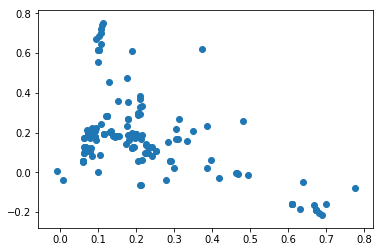

In [20]:
def plot_2d_embeddings(embeddings, n=162):
    # Get 1st and 2nd embedding dims for the first n words
    x1 = embeddings[:n, 0]
    x2 = embeddings[:n, 1]
    
    # Get the corresponding words
    word_list = vocab.ids_to_words(range(n))

    plt.scatter(x=x1, y=x2)
    plt.show()
    
plot_2d_embeddings(embeddings)

## t-SNE for better visualizations

To get a better sense of our embedding structure, we can use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) instead. This is a *non*-linear way of embedding high-dimensional data (like our embedding vectors) into a low-dimensional space. It works by preserving local distances at the expense of some global distortion. The result is no longer a projection, but because it preserves locality, t-SNE helps us better understand neighborhoods in high dimensional space.

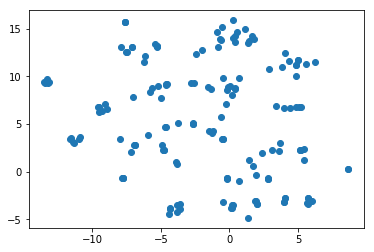

In [21]:
tsne_embeddings = tsne(n_components=2).fit_transform(embeddings[:162])
plot_2d_embeddings(tsne_embeddings)

## Takeaways

We've shown that we can use simple co-occurrences in a text corpus and SVD to create dense embeddings -- representations for words that appear to preserve some of our intuitions about word similarities. A few questions naturally come to mind:

* **Is there some way to *interpret* each dimension of the embeddings?**
Well, no, not really. Because the embeddings arise solely from their distributional properties, we can't guarantee that each dimension will correspond to some intuitive concept. Of course you could try to examine the 2-D plot (not the t-SNE one) and see if you can find an explanation for the first two components -- the $x$ and $y$ axes. Note that some social science disciplines like psychology have used **Factor Analysis** to attempt to rotate embeddings into a pre-defined space with psychological concepts on the axes. But typically in language processing, we simply relinquish control over the inferred semantics.


* **How do we evaluate how *good* the embeddings are?**
Evaluation typically comes in two forms: **intrinsic** and **extrinsic**. Intrinsic evaluation attempts to quantify the quality of the embeddings themselves. A few different annotation projects have attempted to score semantic similarity between pairs of words by averaging human judgements (e.g. see [ConceptSim](http://www.seas.upenn.edu/~hansens/conceptSim/)). So we could ask how well distances between our word embeddings correlate with human judgements. Another related evaluation involves analogies. Can we use Euclidean distances in embeddings space to solve fill-in-the-blanks like: `[man::woman as king::_____]`, which can capture various kinds of syntactic and semantic relationships? See [Chen, Peterson, Griffiths, 2017](https://cocosci.berkeley.edu/papers/vector_space_analogy_cogsci2017_final.pdf) for a lot more details and a cognitive science perspective. By contrast, extrinsic evaluation involves plugging the embeddings into another task and measuring relative improvements.

As it turns out, the co-occurrence plus SVD method is simple, but inferior with respect to both intrinsic and extrinsic evaluation. The Word2Vec ideas introduced in the next notebook revolutionized language processing by dramatically improving embeddings.

## Experiments

(1) Compute the 5 nearest neighbors in our induced 25-dimensional embeddings space for each of the following words:
`["john", "kitchen", "give", "mouse", "she", "blue"]`. Do the results look reasonable? Is this intrinsic or extrinsic evaluation?

(2) Train your embeddings using a real corpus of text. This could be some text you have access to, e.g. some text from Wikipedia, or Shakespeare. You just need to load a corpus of sentences, which you can do by specifying its pathname as the first argument to the BabiTaskCorpusReader function.